## Introduction

[Keras 3](https://keras.io/keras_3/) is a deep learning framework that can be used interchangeably with [TensorFlow](https://www.tensorflow.org/), [JAX](https://jax.readthedocs.io/en/latest/), and [PyTorch](https://pytorch.org/). It is a comprehensive rewrite of Keras that gives us new model training and deployment capabilities by enabling us to run Keras workflows on top of TensorFlow, PyTorch, or JAX. We can select the framework that best fits your needs and alternate between them based on our specifications. Moreover, Keras is a low-level cross-framework language that can be used to develop custom elements like models, layers, or metrics that can be utilized with a single codebase in native workflows in TensorFlow, PyTorch, or JAX. This notebook will guide you through Keras 3 with PyTorch workflows.

## Requirements

Before diving right into the notebook, ensure you meet the following requirement for the code to run smoothly:

Environment with GPU Acceleration: To run this code efficiently, ensure you have access to a environment with GPU acceleration enabled. 1 T-4 GPU is sufficient to run this code. After enabling the GPU, now you can run the code in the notebook.

## Setup

We're going to be using the PyTorch backend here, so we'll need to set the backend first to PyTorch. We'll also import the necessary libraries and modules from Keras and PyTorch.

In [1]:
import os

# Set the backend to PyTorch
os.environ["KERAS_BACKEND"] = "torch"

In [3]:
# Import the required libraries
import numpy as np
import matplotlib.pyplot as plt

# Import the Keras and torch necessities
import keras
from keras import layers

import torch
from torch.utils.tensorboard import SummaryWriter

## Data Preparation


We gonna use the [Fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset for this task. The Fashion MNIST dataset is a dataset of images - consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The classes are T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot.

We'll start by loading the data and preparing it for training. We'll use the [`load_data`](https://keras.io/api/datasets/fashion_mnist/#load_data-function) function to load the data, and then we'll preprocess it as required. Create torch datasets from the given training and validation data.

In [4]:
# Load the Fashion MNIST dataset
(x_train, y_train), (x_val, y_val) = keras.datasets.fashion_mnist.load_data()

# Reshape the data
x_train = np.reshape(x_train, (-1, 784)).astype("float32")
x_val = np.reshape(x_val, (-1, 784)).astype("float32")

# Category labels for the dataset
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)

In [5]:
# Create training and validation datasets
train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(x_train), torch.from_numpy(y_train)
)

val_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(x_val), torch.from_numpy(y_val)
)

## Preparing Dataloader

We'll use the [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class to create dataloaders for the training and validation datasets. We'll set the batch size to 32 and shuffle the training dataloader. We'll keep the validation dataloader as it is.

In [6]:
# Batch size for model training and validation
batch_size = 32

In [7]:
# Create DataLoaders for the training and validation datasets
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

## Data Visualization

We'll visualize a few images from the training dataset. We'll write a function to display the images along with their labels. We'll use the `matplotlib` library to plot the images.

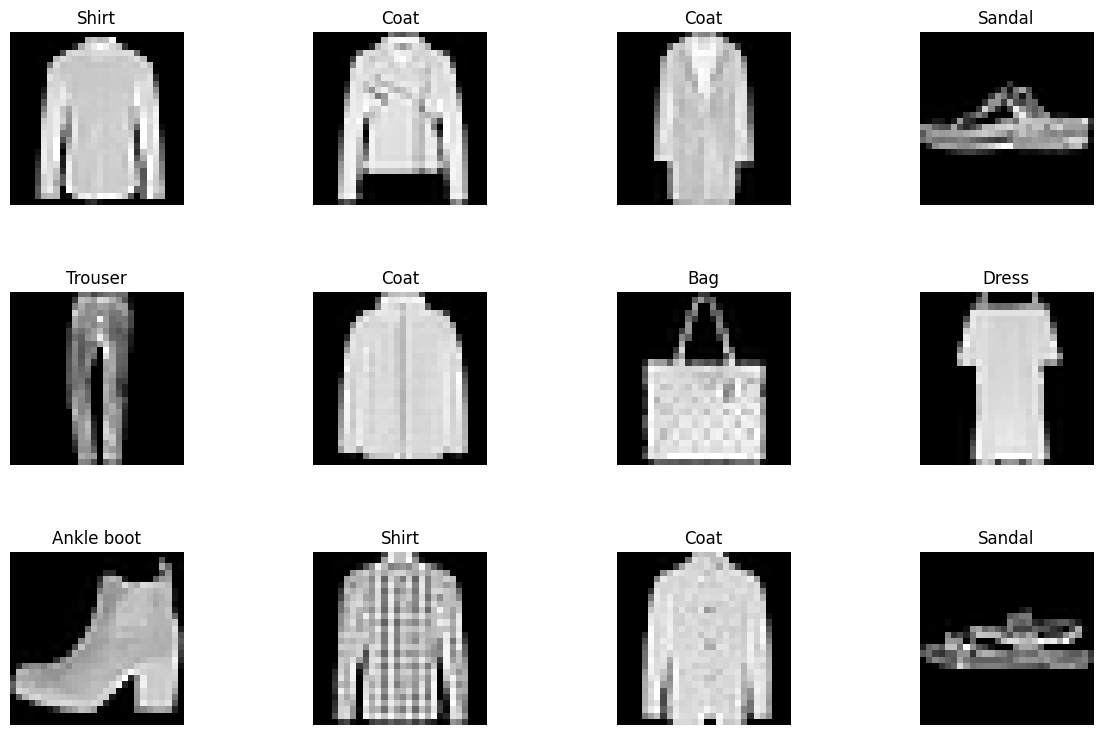

In [8]:
def visualize_batch(dataloader, class_labels):
    """
    Visualizes images along with their labels from the given data loader.

    Args:
        dataloader (torch.utils.data.DataLoader): The data loader containing the batch of images and labels.
        class_labels (list): The list of class labels corresponding to the image labels.

    Returns:
        None
    """

    # Get a batch of images and labels
    images, labels = next(iter(dataloader))

    # Reshape images to original shape (28, 28)
    images = images.view(-1, 28, 28)

    # Create a grid of images
    num_images = len(images)
    num_rows = 3

    fig, axes = plt.subplots(num_rows, 4, figsize=(15, 3 * num_rows))
    fig.subplots_adjust(hspace=0.5)

    # Iterate over the images and labels
    for i, ax in enumerate(axes.flat):
        if i < num_images:

            # Display the image
            ax.imshow(images[i], cmap="gray")
            ax.set_title(class_labels[np.argmax(labels[i])])
            ax.axis("off")
        else:
            ax.axis("off")

    # Display the plot
    plt.show()


# Example usage
class_labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Visualize images from the training data loader
visualize_batch(train_dataloader, class_labels)

## Model Building

We'll build a simple multi-layer perceptron (MLP) model using keras [functional API](https://keras.io/guides/functional_api/). The model will have the following architecture:

- Input layer with 784 units (28x28 pixels)
- Two hidden layers with 64 units each and ReLU activation
- Output layer with 10 units for the 10 classes

In [9]:
def get_model():
    """
    Creates and returns a Keras model for fashion item recognition.

    Returns:
        model (keras.Model): The Keras model for fashion item recognition.
    """
    inputs = keras.Input(shape=(784,), name="fashion_mnist_input")
    x1 = layers.Dense(64, activation="relu")(inputs)
    x2 = layers.Dense(64, activation="relu")(x1)
    outputs = layers.Dense(10, name="predictions")(x2)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Loss, Optimizer & Metrics

Next, here's our optimizer and our loss function. We'll use the CrossEntropyLoss as the loss function and the Adam optimizer with a learning rate 0.001. We'll also use the accuracy metric from Keras to evaluate the model.

In [10]:
# Learning rate for the optimizer
learning_rate = 1e-3

In [11]:
# Get the above defined model
model = get_model()

# Instantiate an optimizer to train the model with
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Instantiate a loss function
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)

# Prepare the metrics to measure the performance of the model
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

## Model Training

Here's our training & evaluation loop for the model. We'll train the model for 5 epochs and evaluate it after each epoch. We'll also keep track of the training and validation loss and accuracy.

In [12]:
# Set the number of epochs 
epochs = 5

In [13]:
# Create a SummaryWriter for logging TensorBoard events
train_writer = SummaryWriter(log_dir='logs/train')
val_writer = SummaryWriter(log_dir='logs/val')

In [14]:
# Iterate over the number of epochs
for epoch in range(epochs):

    # Print the current epoch
    print(f"\nStart of epoch {epoch}")

    for step, (inputs, targets) in enumerate(train_dataloader):

        inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
        
        # Forward pass of the model
        logits = model(inputs)
        loss = loss_fn(targets, logits)

        # Backward pass for the gradients
        model.zero_grad()
        trainable_weights = [v for v in model.trainable_weights]

        # Call torch.Tensor.backward() on the loss to compute gradients for the weights.
        loss.backward()
        gradients = [v.value.grad for v in trainable_weights]

        # Update weights
        with torch.no_grad():
            optimizer.apply(gradients, trainable_weights)

        # Update training metrics
        train_acc_metric.update_state(targets, logits)

        # Log training loss to TensorBoard
        train_writer.add_scalar('Loss', loss.item(), epoch * len(train_dataloader) + step)

        # Log every 100 batches to track progress of training
        if step % 100 == 0:
            print(
                f"Training loss (for 1 batch) at step {step}: {loss.cpu().detach().numpy():.4f}"
            )
            print(f"Seen so far: {(step + 1) * batch_size} samples")

    # Display training metrics at the end of each epoch
    train_acc = train_acc_metric.result()
    print(f"Training acc over epoch: {float(train_acc):.4f}")

    # Log training accuracy to TensorBoard
    train_writer.add_scalar('Accuracy', train_acc.item(), epoch)

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_state()

    # Run a validation loop at the end of each epoch
    for x_batch_val, y_batch_val in val_dataloader:

        # validation set logits
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)

    # Validation metrics at the end of each epoch
    val_acc = val_acc_metric.result()

    # Log validation accuracy to TensorBoard
    val_writer.add_scalar('Accuracy', val_acc, epoch)

    # Reset validation metrics at the end of each epoch
    val_acc_metric.reset_state()

    # Print validation accuracy
    print(f"Validation acc: {float(val_acc):.4f}")

# Close the SummaryWriter
train_writer.close()
val_writer.close()


Start of epoch 0
Training loss (for 1 batch) at step 0: 230.1421
Seen so far: 32 samples
Training loss (for 1 batch) at step 100: 3.6940
Seen so far: 3232 samples
Training loss (for 1 batch) at step 200: 3.3105
Seen so far: 6432 samples
Training loss (for 1 batch) at step 300: 1.5470
Seen so far: 9632 samples
Training loss (for 1 batch) at step 400: 0.8357
Seen so far: 12832 samples
Training loss (for 1 batch) at step 500: 0.9189
Seen so far: 16032 samples
Training loss (for 1 batch) at step 600: 0.8999
Seen so far: 19232 samples
Training loss (for 1 batch) at step 700: 1.0149
Seen so far: 22432 samples
Training loss (for 1 batch) at step 800: 1.1279
Seen so far: 25632 samples
Training loss (for 1 batch) at step 900: 0.8304
Seen so far: 28832 samples
Training loss (for 1 batch) at step 1000: 0.7572
Seen so far: 32032 samples
Training loss (for 1 batch) at step 1100: 0.8937
Seen so far: 35232 samples
Training loss (for 1 batch) at step 1200: 0.8291
Seen so far: 38432 samples
Training l

## Conclusion

We've successfully trained a simple MLP model for the Fashion MNIST dataset. We achieved good accuracy on the validation set. However, we can further improve the model by tuning the hyperparameters, adding more layers, or using a different architecture. This is just an example notebook to demonstrate how to train a model using multi-backend Keras. The purpose of this notebook is to provide a simple example of how to train a model using multi-backend Keras keeping the spirit of PyTorch intact. We also have a Python training script for the same using a simple convnet model. To check the script, please refer to the `main.py` file in the root directory of this project.

That's all for this notebook!